# Functions

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


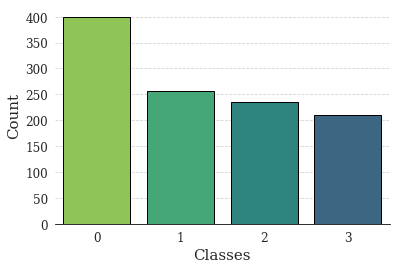

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

df = pd.read_csv('/content/drive/MyDrive/SANDBOX/DATA/train_images.csv')

sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize = (6, 4))

for i in ['top', 'right', 'left']:
    ax.spines[i].set_visible(False)
ax.spines['bottom'].set_color('black')

sns.countplot(df.class_num, edgecolor = 'black',
              palette = reversed(sns.color_palette("viridis", 5)))
plt.xlabel('Classes', fontfamily = 'serif', size = 15)
plt.ylabel('Count', fontfamily = 'serif', size = 15)
plt.xticks(fontfamily = 'serif', size = 12)
plt.yticks(fontfamily = 'serif', size = 12)
ax.grid(axis = 'y', linestyle = '--', alpha = 0.9)
plt.show()

# Static

In [ ]:
TRAIN_PATH = '/content/drive/MyDrive/SANDBOX/DATA/train_images.csv'
TEST_PATH = '/content/drive/MyDrive/SANDBOX/DATA/test_images.csv'
SAMPLE_PATH = '/content/drive/MyDrive/SANDBOX/DATA/sample_submit.csv'

TRAIN_IMAGE_PATH = '/content/drive/MyDrive/SANDBOX/DATA/train_images'
TEST_IMAGE_PATH = '/content/drive/MyDrive/SANDBOX/DATA/test_images'

IMAGE_SIZE = 640
BATCH_SIZE = 4
EPOCHS = 100

DROPOUT_RATE = 0.2

# Import data

In [ ]:
import pandas as pd

pd.set_option('display.max_colwidth', 100)

df = pd.read_csv(TRAIN_PATH)
df_test = pd.read_csv(TEST_PATH)

df['id'] = TRAIN_IMAGE_PATH+'/'+df['id']

df['class_num'] = df['class_num'].astype(str)

print('df shape: {0}, df_test shape: {1}'.format(df.shape, df_test.shape))

df shape: (1103, 2), df_test shape: (1650, 1)


# ImageDataGenerator

[ImageDataGenerator](https://keras.io/ja/preprocessing/image/)

In [ ]:
from sklearn.model_selection import train_test_split

df_train, df_val = train_test_split(df, test_size=0.1, random_state=2021)

from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(featurewise_center=False,
                                   samplewise_center=False,
                                   featurewise_std_normalization=False,
                                   samplewise_std_normalization=False,
                                   zca_whitening=False,
                                   rotation_range=180,
                                   width_shift_range=1.0,
                                   height_shift_range=1.0,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   channel_shift_range=0.0,
                                   fill_mode='nearest',
                                   cval=0.0,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   rescale=1./255.,
                                   preprocessing_function=None,
                                   data_format=None,)
# train_datagen = ImageDataGenerator(rescale=1./255.)
val_datagen = ImageDataGenerator(rescale=1./255.)

train_generator = train_datagen.flow_from_dataframe(df_train, directory=TRAIN_IMAGE_PATH, x_col='id', y_col='class_num', target_size=(IMAGE_SIZE, IMAGE_SIZE), batch_size=BATCH_SIZE, class_mode='sparse')
val_generator = val_datagen.flow_from_dataframe(df_val, directory=TRAIN_IMAGE_PATH, x_col='id', y_col='class_num', target_size=(IMAGE_SIZE, IMAGE_SIZE), batch_size=BATCH_SIZE, class_mode='sparse')
# train_generator = train_datagen.flow_from_dataframe(df, directory=TRAIN_IMAGE_PATH, x_col='id', y_col='class_num', target_size=(IMAGE_SIZE, IMAGE_SIZE), batch_size=BATCH_SIZE, class_mode='sparse')

for data_batch, labels_batch in train_generator:
  print('data batch shape: ', data_batch.shape)
  print('labels batch shape: ', labels_batch.shape)
  break

Found 992 validated image filenames belonging to 4 classes.
Found 111 validated image filenames belonging to 4 classes.
data batch shape:  (4, 640, 640, 3)
labels batch shape:  (4,)


# Create model and Fine Tuning

In [ ]:
from keras import models
from tensorflow.keras.applications import EfficientNetB0, VGG16
from keras.layers import GlobalAveragePooling2D, BatchNormalization, Dropout, Dense
from keras.optimizers import Adam

model = models.Sequential()

# conv_base = EfficientNetB0(weights='imagenet', input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False)
conv_base = VGG16(weights='imagenet', input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False)

model.add(conv_base)
model.add(GlobalAveragePooling2D())
model.add(Dropout(DROPOUT_RATE))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(DROPOUT_RATE))
model.add(Dense(4, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(lr=1e-5), metrics=['accuracy'])

# Callbacks and Training

In [ ]:
# from keras.callbacks import ReduceLROnPlateau
import time

# callbacks_list = [ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5)]

start = time.time()

history = model.fit(train_generator, epochs=EPOCHS, validation_data=val_generator)
# history = model.fit(train_generator, epochs=EPOCHS, callbacks=callbacks_list, validation_data=val_generator)
# history = model.fit(train_generator, epochs=EPOCHS)

elapsed_time = time.time() - start
print('Elapsed time: {:.1f}[min]'.format(elapsed_time / 60))

Epoch 1/100
248/248 [==============================] - 422s 2s/step - loss: 1.3319 - accuracy: 0.3702 - val_loss: 0.7037 - val_accuracy: 0.6486
Epoch 2/100
248/248 [==============================] - 325s 1s/step - loss: 0.8059 - accuracy: 0.6304 - val_loss: 0.5198 - val_accuracy: 0.7568
Epoch 3/100
248/248 [==============================] - 326s 1s/step - loss: 0.5771 - accuracy: 0.7693 - val_loss: 0.3833 - val_accuracy: 0.8378
Epoch 4/100
248/248 [==============================] - 325s 1s/step - loss: 0.4519 - accuracy: 0.8237 - val_loss: 0.3229 - val_accuracy: 0.8649
Epoch 5/100
248/248 [==============================] - 324s 1s/step - loss: 0.3488 - accuracy: 0.8728 - val_loss: 0.2158 - val_accuracy: 0.9099
Epoch 6/100
248/248 [==============================] - 324s 1s/step - loss: 0.2925 - accuracy: 0.8938 - val_loss: 0.1977 - val_accuracy: 0.9189
Epoch 7/100
248/248 [==============================] - 324s 1s/step - loss: 0.2747 - accuracy: 0.9008 - val_loss: 0.1793 - val_accuracy:

# Evaluate

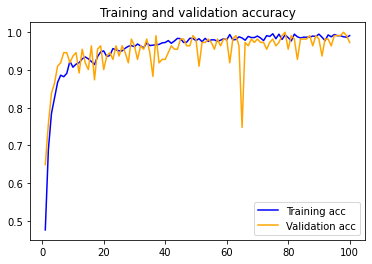

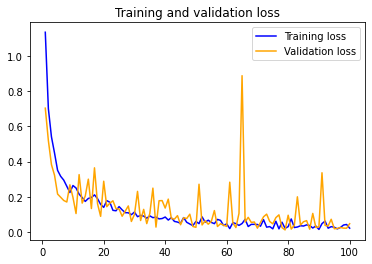

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, EPOCHS + 1)

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'b', color='orange', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.show()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'b', color='orange', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# Submit

In [ ]:
import numpy as np
from PIL import Image

preds = []

for image_id in df_test['id']:
    image = Image.open(TEST_IMAGE_PATH+'/'+image_id)
    image = image.resize((IMAGE_SIZE, IMAGE_SIZE))
    image = np.expand_dims(image, axis=0)
    image = image/255.
    preds.append(np.argmax(model.predict(image)))

df_test['label'] = preds

df_test.to_csv('/content/drive/MyDrive/SANDBOX/DATA/submission.csv', index=False, header=False)

df_test.head()

,id,label
0,20191230123923551268263136.jpg,0
1,2019123012404359456294433.jpg,0
2,20191230110837916079015300.jpg,1
3,20191230125230475138321091.jpg,3
4,20191230123323653945251927.jpg,0


In [ ]:
print(df[df['id'] == TRAIN_IMAGE_PATH+'/'+'20191230130928502301722457.jpg']['class_num'])
print(df[df['id'] == TRAIN_IMAGE_PATH+'/'+'20191230130924467198861333.jpg']['class_num'])

print(df_test[df_test['id'] == '20191230131007671310762298.jpg']['label'])
print(df_test[df_test['id'] == '20191230130730876676285146.jpg']['label'])
print(df_test[df_test['id'] == '20191230131003549073672954.jpg']['label'])
print(df_test[df_test['id'] == '20191230130911762718768948.jpg']['label'])

194    3
Name: class_num, dtype: object
587    3
Name: class_num, dtype: object
626    3
Name: label, dtype: int64
722    3
Name: label, dtype: int64
864    3
Name: label, dtype: int64
1473    3
Name: label, dtype: int64


In [ ]:
print(df[df['id'] == TRAIN_IMAGE_PATH+'/'+'20191230130336308845530637.jpg']['class_num'])
print(df[df['id'] == TRAIN_IMAGE_PATH+'/'+'20191230130340421281496453.jpg']['class_num'])
print(df[df['id'] == TRAIN_IMAGE_PATH+'/'+'20191230130354872946592725.jpg']['class_num'])

print(df_test[df_test['id'] == '2019123013035030758870363.jpg']['label'])
print(df_test[df_test['id'] == '20191230130324238528847833.jpg']['label'])

537    3
Name: class_num, dtype: object
723    3
Name: class_num, dtype: object
910    3
Name: class_num, dtype: object
1321    3
Name: label, dtype: int64
1644    3
Name: label, dtype: int64


# Google Colab

```javascript
function ClickConnect(){ 
console.log("Working"); 
document.querySelector("#comments > span").click()
}
setInterval(ClickConnect,500000)
```